In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import odeint, solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage.filters import laplace, convolve1d
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

In [2]:
def gaussian(x):
    y = np.exp(-0.5 * x ** 2) / sqrt(2 * np.pi)
    return y


def cdf_gaussian(x):
    y = 0.5 * (1 + erf(x / sqrt(2)))
    return y


def trunc_gaussian(x, mu, sigma, a=0, b=1):
    xi = (x - mu) / sigma
    beta = (b - mu) / sigma
    alpha = (a - mu) / sigma
    y = gaussian(xi) / sigma
    y /= cdf_gaussian(beta) - cdf_gaussian(alpha)
    return y


def dydt_int(t, y, alpha, r_d, var, a_min, a_max):
    dalpha = alpha[1] - alpha[0]
    #     rho = y.sum() * dalpha
    rho = np.trapz(y, dx=dalpha)
    dy = np.empty_like(y)
    for i, a in enumerate(alpha):
        dy[i] = np.trapz(alpha * y * trunc_gaussian(a - alpha, 0., sqrt(var), a=a_min - alpha, b=a_max - alpha),
                         dx=dalpha)

    #     dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    return dy

# first order approximation
def dydt(t, y, alpha, r_d, v):
    da = alpha[1] - alpha[0]
    rho = np.trapz(y, dx=da)
    alpharho = alpha * y
    dy = alpharho + v * laplace(alpharho)
    dy *= 1 - rho
    dy -= r_d * y
    return dy


In [27]:
a_max = 1.
alpha, dalpha = np.linspace(0, a_max, num=201, retstep=True)
r_d = 0.02
r_b = 0.1
var = 0.005**2
tmax = 3000
Da = var / dalpha**2
dens0 = 1 - r_d / r_b
ts = np.linspace(0, tmax, num=11)
y0 = np.zeros_like(alpha)
y0[np.argwhere(alpha==r_b)] = dens0 / dalpha
sol = solve_ivp(dydt_int, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, var, 0., a_max)).y.T
sol2 = solve_ivp(dydt, (0, tmax), y0, t_eval=ts, args=(alpha, r_d, Da), method='DOP853').y.T

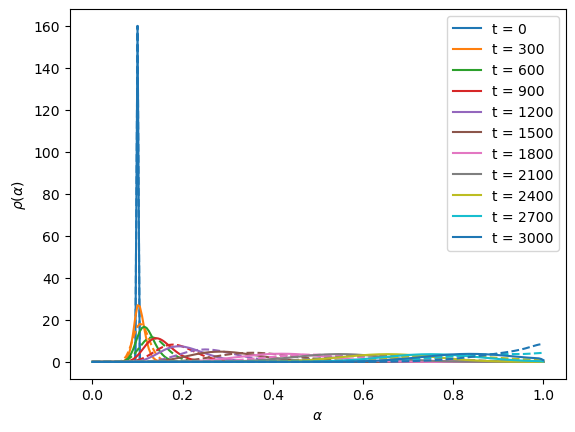

In [28]:
for t in np.arange(len(ts)):
    p = plt.plot(alpha, sol[t], label='t = {:n}'.format(ts[t]))
    plt.plot(alpha, sol2[t], '--', label='_t = {:n}'.format(ts[t]), color=p[0].get_color())

#plt.plot(alpha, sol[-1], label='t = {:n}'.format(ts[-1]))
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha)$')
plt.legend()

In [29]:
lgca = get_lgca(ib=True, density=dens0, bc='reflect', interaction='birthdeath', std=sqrt(var),
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='1d', dims=1, restchannels=1000)
lgca.timeevo(timesteps=tmax, record=True)

Family relationships not tracked.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:48<00:00, 62.36it/s]


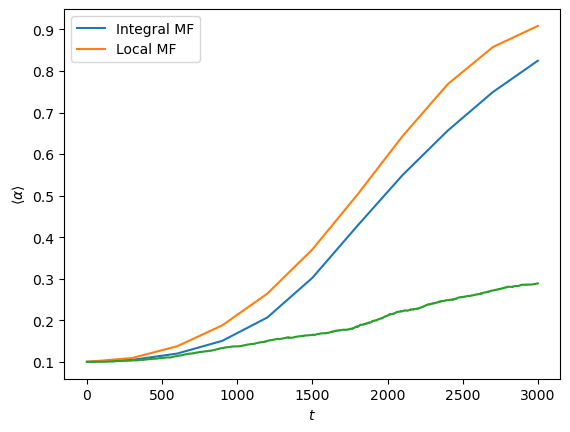

In [30]:
plt.plot(ts, np.trapz(sol * alpha, dx=dalpha) / np.trapz(sol, dx=dalpha), label='Integral MF')
plt.plot(ts,  np.trapz(sol2 * alpha, dx=dalpha) / np.trapz(sol2, dx=dalpha), label='Local MF')
lgca.plot_prop_timecourse()
plt.title('')
plt.ylabel('$\\langle\\alpha\\rangle$')
plt.legend()

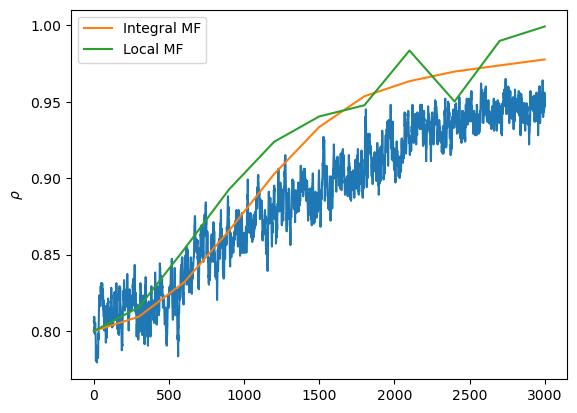

In [31]:
plt.plot(np.arange(len(lgca.dens_t)), lgca.dens_t/lgca.K)
plt.plot(ts, sol.sum(-1) * dalpha, label='Integral MF')
plt.plot(ts, sol2.sum(-1) * dalpha, label='Local MF')

plt.title('')
plt.ylabel('$\\rho$')
plt.legend()
plt.show()

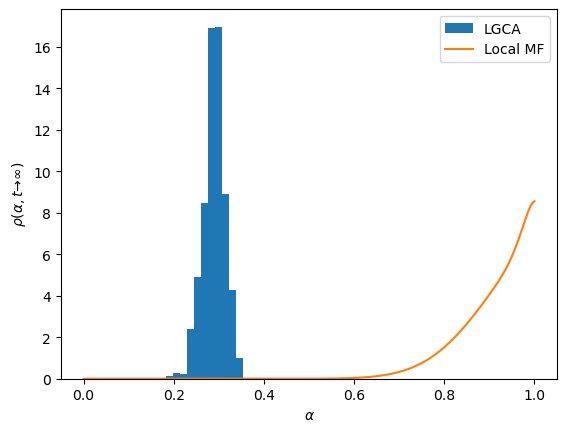

In [32]:
bins = int(np.ceil(np.log2(lgca.occupied.sum()))+1)
plt.hist(np.array(lgca.props['r_b'])[lgca.nodes[lgca.nodes > 0]], bins=bins, density=True, label='LGCA')
# plt.plot(alpha, sol[-1] / sol[-1].sum() / dalpha, label='Int MF')
plt.plot(alpha, sol2[-1] / sol2[-1].sum() / dalpha, label='Local MF')
plt.xlabel('$\\alpha$')
plt.ylabel('$\\rho(\\alpha, t \\to \\infty)$')
plt.legend()